# Jupyter Rigol Scope Utility

This Jupyter Notebook serves as a utility for downloading data from a Rigol digital oscilloscope, allowing  you to plot and analyze the data in *Python*.

## Quickstart:

1 - Make sure NI-Visa is installed on your computer. (See https://www.ni.com/visa/) and that the `pyvisa` package is avialable in your *Python* installation. (You can install `pyvisa` using `pip`: 

> `$ pip install -U pyvisa`

.)

2 -Connect a Rigol oscilloscope to a USB  port on your computer. (_Warning_: The auto-address scheme used here may fail if there are other USB instruments connected to your computer during the initialiization process.)

3 - Before you can retrieve data from the oscilloscope you need to run the cell below that contains ~ 150 lines of *Python* code . Running this cell initialzes the USB connection, imports the necessary *Python* packages, and defines the *Python* functions that are used to interact with the oscilloscope. After running this initialization code, check the output cell. If things went went well there will not be any error messages, only a printout of the USB address and identity of the oscilloscope. 

4- The following scope related *Python* functions should now be available:

The `getscope()` function retrieves all active scope traces and also creates a plot of the traces. The syntax is:

> `data=getscope()`
      
The `save()` function stores the retrieved data in a comma delimited textfile. The syntax is:

> `save(data, 'filename.csv')`

The `load()` function retrieves data stored in a comma delimited textfile. The syntax is:

> `data=load('filename.csv')`

**More detailed documentation on these cope related *Python* functions can be found in the last cell of this notebook.**



## Initialization code:

In [1]:
# read, plot and store data from Rigol 4-channel scope
# Run this cell
import pyvisa
import visa
import sys
import time
import numpy as np
import matplotlib.pyplot as plt # provides a MATLAB-like way of plotting.
from struct import unpack
import csv # for reading and writing comma separated text files

# %matplotlib inline

rm = visa.ResourceManager()
resources=rm.list_resources()
addr=resources[0]
print(addr)
print ('\n')
scope=rm.open_resource(addr)

id=scope.query('*IDN?')
print(id)



def getscope():
    #scope.write(":STOP")
    timescale = float(scope.query(":TIM:SCAL?"))
    #print('timescale = ', timescale)
    xincr=timescale/100
    timeoffset = float(scope.query(":TIM:OFFS?"))

    dt = float(scope.query(':WAVeform:XINCrement?'))
    yoff = float(scope.query(":CHAN1:OFFS?"))
    scope.write(":WAV:POIN:MODE NOR")
    channels = []
    for i in range(1,5):
        name = ':CHAN' + str(i) + ':DISP?'
        x=int(scope.query(name))
        if x==1:
            channels.append(i)
    labels=['time']
    for k in channels:
        labels.append('Channel ' + str(k))
    datalength=len(labels)+1
    print('The output list has ', datalength, 'elements:')
    print('The zeroth element is a list of labels and the remaining elements are lists of:', labels)
    
    
    color = ['y','c','m','b']
    res=[labels]
    
    j=1
    plt.figure(figsize=(12,8)) #units are inches
    plt.grid(True)
    plt.ylim((0, 255))   # set the ylim to bottom, top
    for i in channels:
        name = ':WAV:SOUR CHAN' + str(i)
        scope.write(name)
        scope.write(":WAV:DATA?")
        ch=scope.read_raw()
        print(len(ch))
        headerlen = 11
        header = ch[:headerlen]
        ch = ch[headerlen:-1]
        ch = np.array(unpack('%sB' % len(ch),ch))
        t = np.linspace(0, dt * len(ch), len(ch)) # construct time array same length as voltage curve
        plt.plot(t,ch,color[i-1])
        #plt.ylabel('Channel ' + str(i) + ' (Volts)') # label the y-axis

        name = ':CHAN' + str(i) + ':SCAL?'
        yscale = float(scope.query(name))
        name = ':CHAN' + str(i) + ':OFFS?'
        yoff = float(scope.query(name))
        ch = (ch-130)*yscale/25 - yoff
        if j==1:
            res.append(t)
        res.append(ch)
        j=j+1
    plt.xlabel('Time (sec)')
    plt.ylabel('Screen Position (0-255)')
    return res
    
def save(data,filename='scopedata.csv'):
    labels=data.pop(0)
    def transpose(x):
        res = [[0]*len(x) for i in range(len(x[0]))] # generate an zero-filled matrix of appropriate size
        for i in range(len(x)):
            for j in range(len(x[0])):
                res[j][i] = x[i][j]
        return res
    data=transpose(data)
    
    # write data to csv file 
    #dataFile = open(filename, 'w')  
    with  open(filename, 'w',newline='') as dataFile:  
       writer = csv.writer(dataFile)
       writer.writerow(labels)
       writer.writerows(data)


#read scopedata from csv file and plot

def load(filename='scopedata.csv'):

    # convert an array of strings to an array of floats
    def convert_str_float(x):
        res=[]
        for s in x:
            res.append(float(s))
        return res
    
    with open(filename) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        labels=next(readCSV)
        #print(labels)
        rowdata=[]
        for row in readCSV:
            row=convert_str_float(row)
            rowdata.append(row)
    
    
    
    def transpose(x):
        res = [[0]*len(x) for i in range(len(x[0]))] # generate an zero-filled matrix of appropriate size
        for i in range(len(x)):
            for j in range(len(x[0])):
                res[j][i] = x[i][j]
        return res

    data=transpose(rowdata)
    data.insert(0,labels)
    print(data[0])
    num=len(data[0])
    color = ['y','c','m','b']
    plt.figure(figsize=(12,6)) #units are inches

    for i in range(1,num):
        plt.subplot(num-1,1,i)
        plt.plot(data[1],data[i+1],color[i-1])
        plt.ylabel(data[0][i]) # label the y-axis

    return data

USB0::0x1AB1::0x04CE::DS1ZA171610116::INSTR


RIGOL TECHNOLOGIES,DS1104Z,DS1ZA171610116,00.04.03



## Run scope commands here:

The output list has  4 elements:
The zeroth element is a list of labels and the remaining elements are lists of: ['time', 'Channel 1', 'Channel 2']
1212
1212


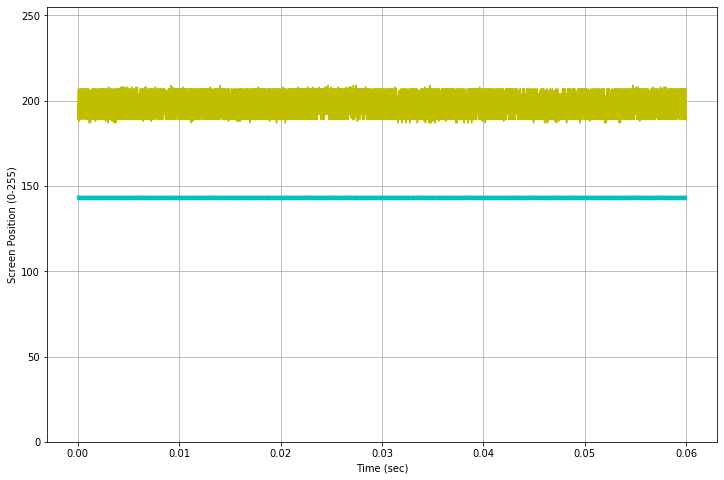

In [3]:
data=getscope()

# More documentation on the scope functions 

The `getscope()` function retrieves all active scope traces and also creates a plot of the traces. The syntax is:

> `data=getscope()}`
      
The retrieved information is stored in a list (called "data" in this example). The 0th element in this list is itself a list that contains the labels associated with the subsequent elements. The 1st element of the list is a list of floating point numbers that gives the times (in seconds) at which the which the data in the subsequent elements were recorded. The 2nd element in the list gives is a list of the voltages (measured in volts) of the first active trace, *etc.*. 

So, for example, if channels 1 and 2 are active then the following code creates two plots. Figure 1 shows both chanels, with the vertical scale in "screen" units.

Figure 2 shows a plot of just channel 2 (in volts).

The output list has  4 elements:
The zeroth element is a list of labels and the remaining elements are lists of: ['time', 'Channel 1', 'Channel 2']
1212
1212
['time', 'Channel 1', 'Channel 2']


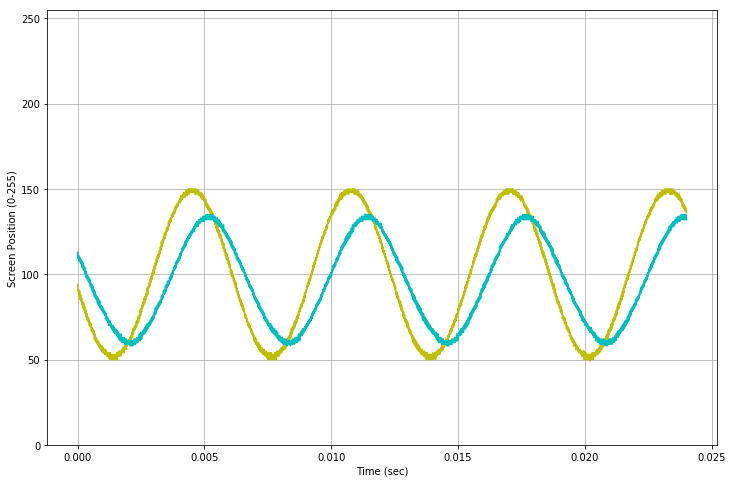

<Figure size 432x288 with 0 Axes>

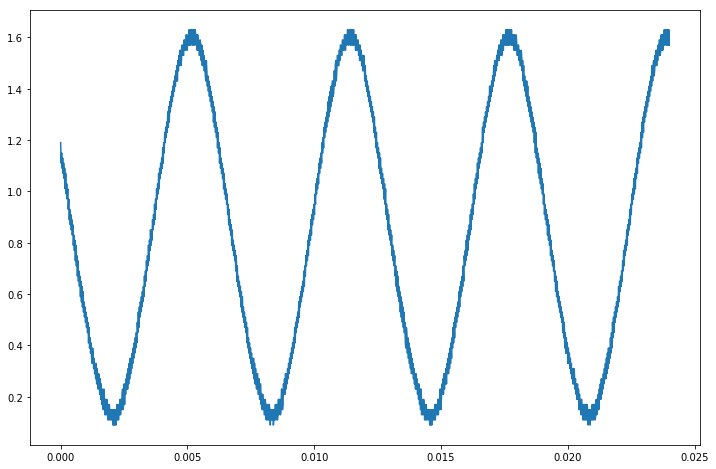

In [197]:
data=getscope()
plt.figure(num=1,figsize=(12, 8))
plt.plot(data[1],data[2])
plt.plot(data[1],data[3])
plt.figure(num=2,figsize=(12, 8))
plt.plot(data[1],data[3])

will create a plot of the voltages recorded on channel 1 as a function of time and will print the labels "time" and "Channel 1". 

**Example:** Suppose channels 1 and 3 are both active on the scope. Running the following will add voltage plots of channels 1 and 3

In [ ]:
[labels, t,ch1,ch3] = getscope()
print(labels)
plt.figure(2)
plt.plot(t,ch1,'y')
plt.figure(3)
plt.plot(t,ch3,'m')

The `save()` function stores the retrieved data in a comma delimited textfile. The syntax is:

> `save(data, 'filename.csv')}`

This save the retrieved data in a comma delimited text file called "yourdata.csv". (If you omit the filename then the data will be stored in a file called "scopedata.csv".) The data is stored in columns with appropriate headings. The saved file can be imported into a spreadsheet program such as *Excel* or *Google Sheets*. 

The `load()` function retrieves data stored in a comma delimited textfile. The syntax is:

> `data=load('filename.csv')}`
    
This will load the csv file into the list called "data". (The format of this list is the same as the one created by `getscope()`. (If you omit the filename then the data will be loaded from the file called "scopedata.csv".)